In [ ]:
# re upload files everytime run

from google.colab import files

uploaded = files.upload()

Saving WBA.xlsx to WBA.xlsx


In [ ]:
# load data

import pandas as pd
import numpy as np

df = pd.ExcelFile("WBA.xlsx").parse("Absorbance") # 239 rows, 146 columns
df['RowNum'] = np.arange(len(df)) # use row number as identifier
#print(df.iloc[:,30:].columns)
#print(df.loc[df['RowNum'] == 168, ['Subject','EarSide']])
#df.drop([153,97,168,49,114,70,189,15,83], axis=0, inplace=True) # remove outliers
#df = df[df['OverallPoF'] == 0] # just keep normal data

X = df.iloc[:,39:-1] # just keep frequency columns
y = df['OverallPoF']

print(X.shape) # 192 rows, 107 columns
print(y.shape)

(239, 107)
(239,)


In [ ]:
# split data into train and validation set

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(203, 107)
(203,)
(36, 107)
(36,)


In [ ]:
# standardise data

#from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.fit_transform(X_test)

In [ ]:
## Load libraries

from tensorflow import keras
print('Tensorflow/Keras: %s' % keras.__version__)

from keras.models import Model
from keras import Input
from keras.layers import Dense, Lambda
from tensorflow.keras.utils import plot_model
from keras import backend as K

import numpy as np
print('numpy: %s' % np.__version__)

import matplotlib
import matplotlib.pyplot as plt
print('matplotlib: %s' % matplotlib.__version__)

import graphviz
print('graphviz: %s' % graphviz.__version__)

import plotly
import plotly.express as px
print('plotly: %s' % plotly.__version__)

import sys
import os

main_dir=os.path.dirname(sys.path[0])
print('main dir: %s' % main_dir)

Tensorflow/Keras: 2.8.0
numpy: 1.21.6
matplotlib: 3.2.2
graphviz: 0.10.1
plotly: 5.5.0
main dir: /


In [ ]:
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (203, 107)
Shape of y_train:  (203,)
Shape of X_test:  (36, 107)
Shape of y_test:  (36,)


In [ ]:
## reparameterisation trick

def sampling(args):
  z_mean, z_log_sigma = args
  epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
  return z_mean + K.exp(z_log_sigma) * epsilon

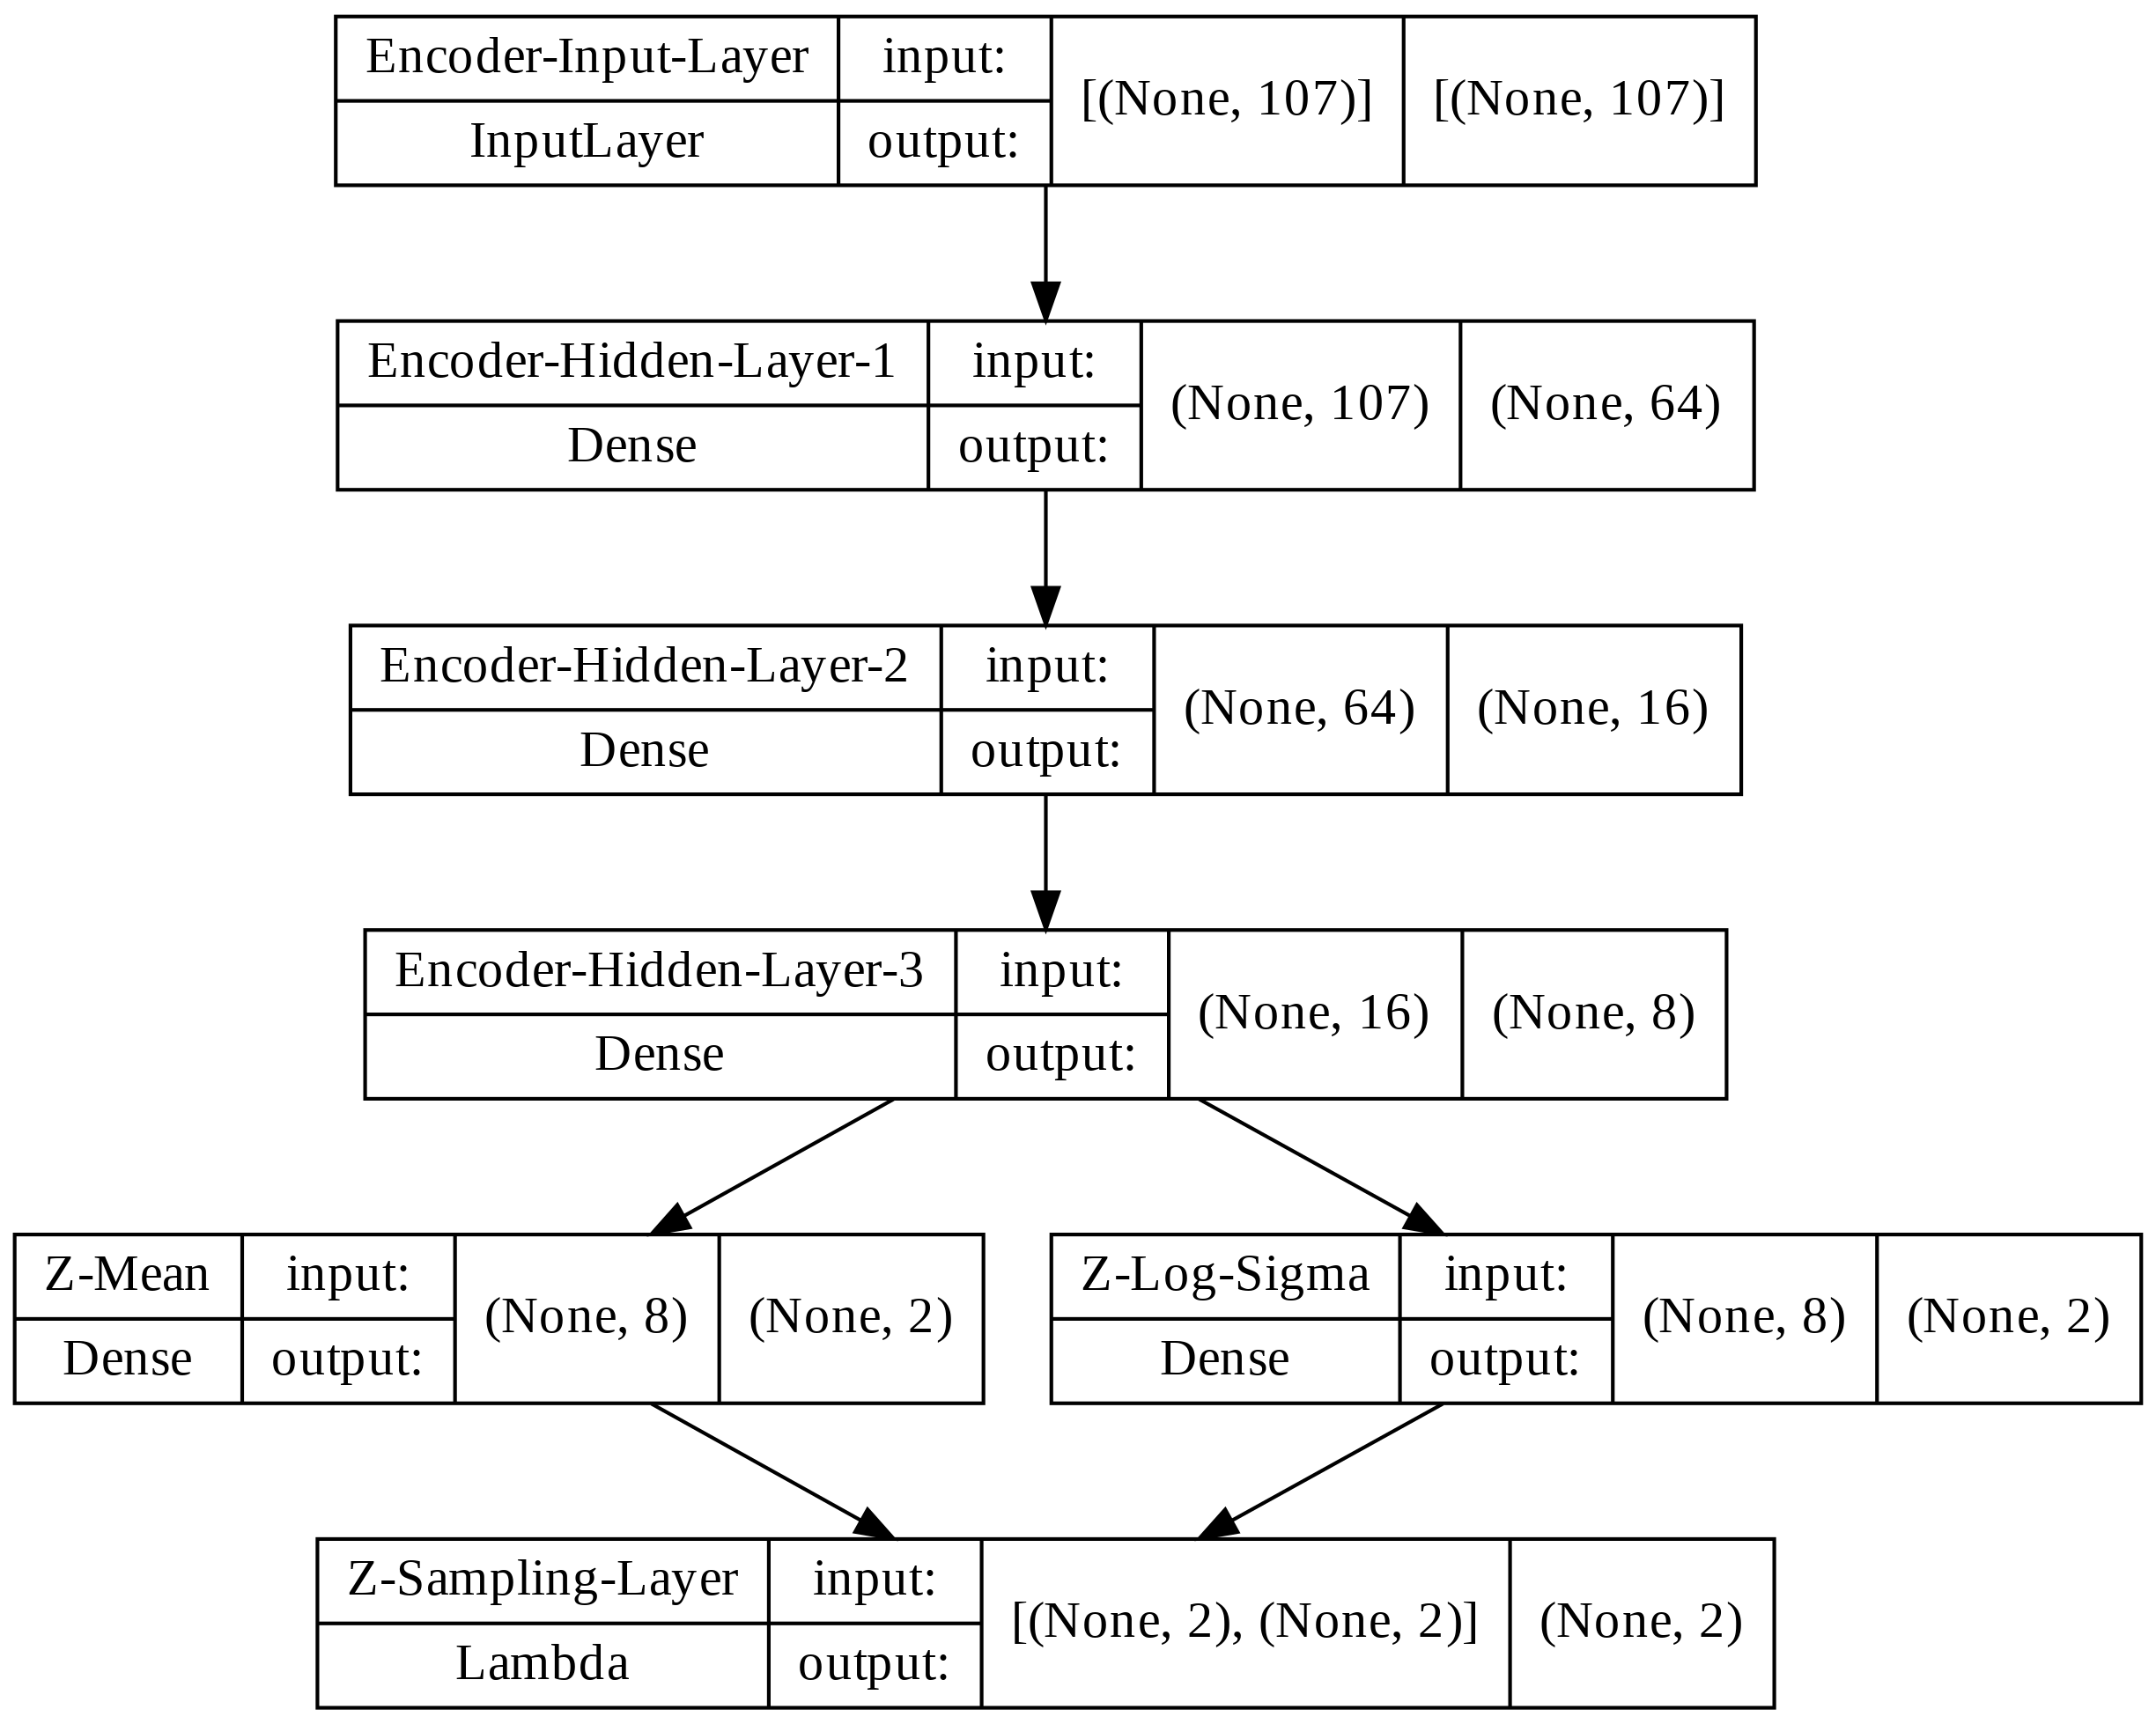

In [ ]:
## Encoder

original_dim = 107
latent_dim = 2

visible = keras.Input(shape=(original_dim,), name='Encoder-Input-Layer')

h_enc1 = Dense(units=64, activation='selu', name='Encoder-Hidden-Layer-1')(visible)
h_enc2 = Dense(units=16, activation='selu', name='Encoder-Hidden-Layer-2')(h_enc1)
h_enc3 = Dense(units=8, activation='selu', name='Encoder-Hidden-Layer-3')(h_enc2)

z_mean = Dense(units=latent_dim, name='Z-Mean')(h_enc3)
z_log_sigma = Dense(units=latent_dim, name='Z-Log-Sigma')(h_enc3)
z = Lambda(sampling, name='Z-Sampling-Layer')([z_mean, z_log_sigma])

encoder = Model(visible, [z_mean, z_log_sigma, z], name='Encoder-Model')

plot_model(encoder, show_shapes=True, dpi=300)

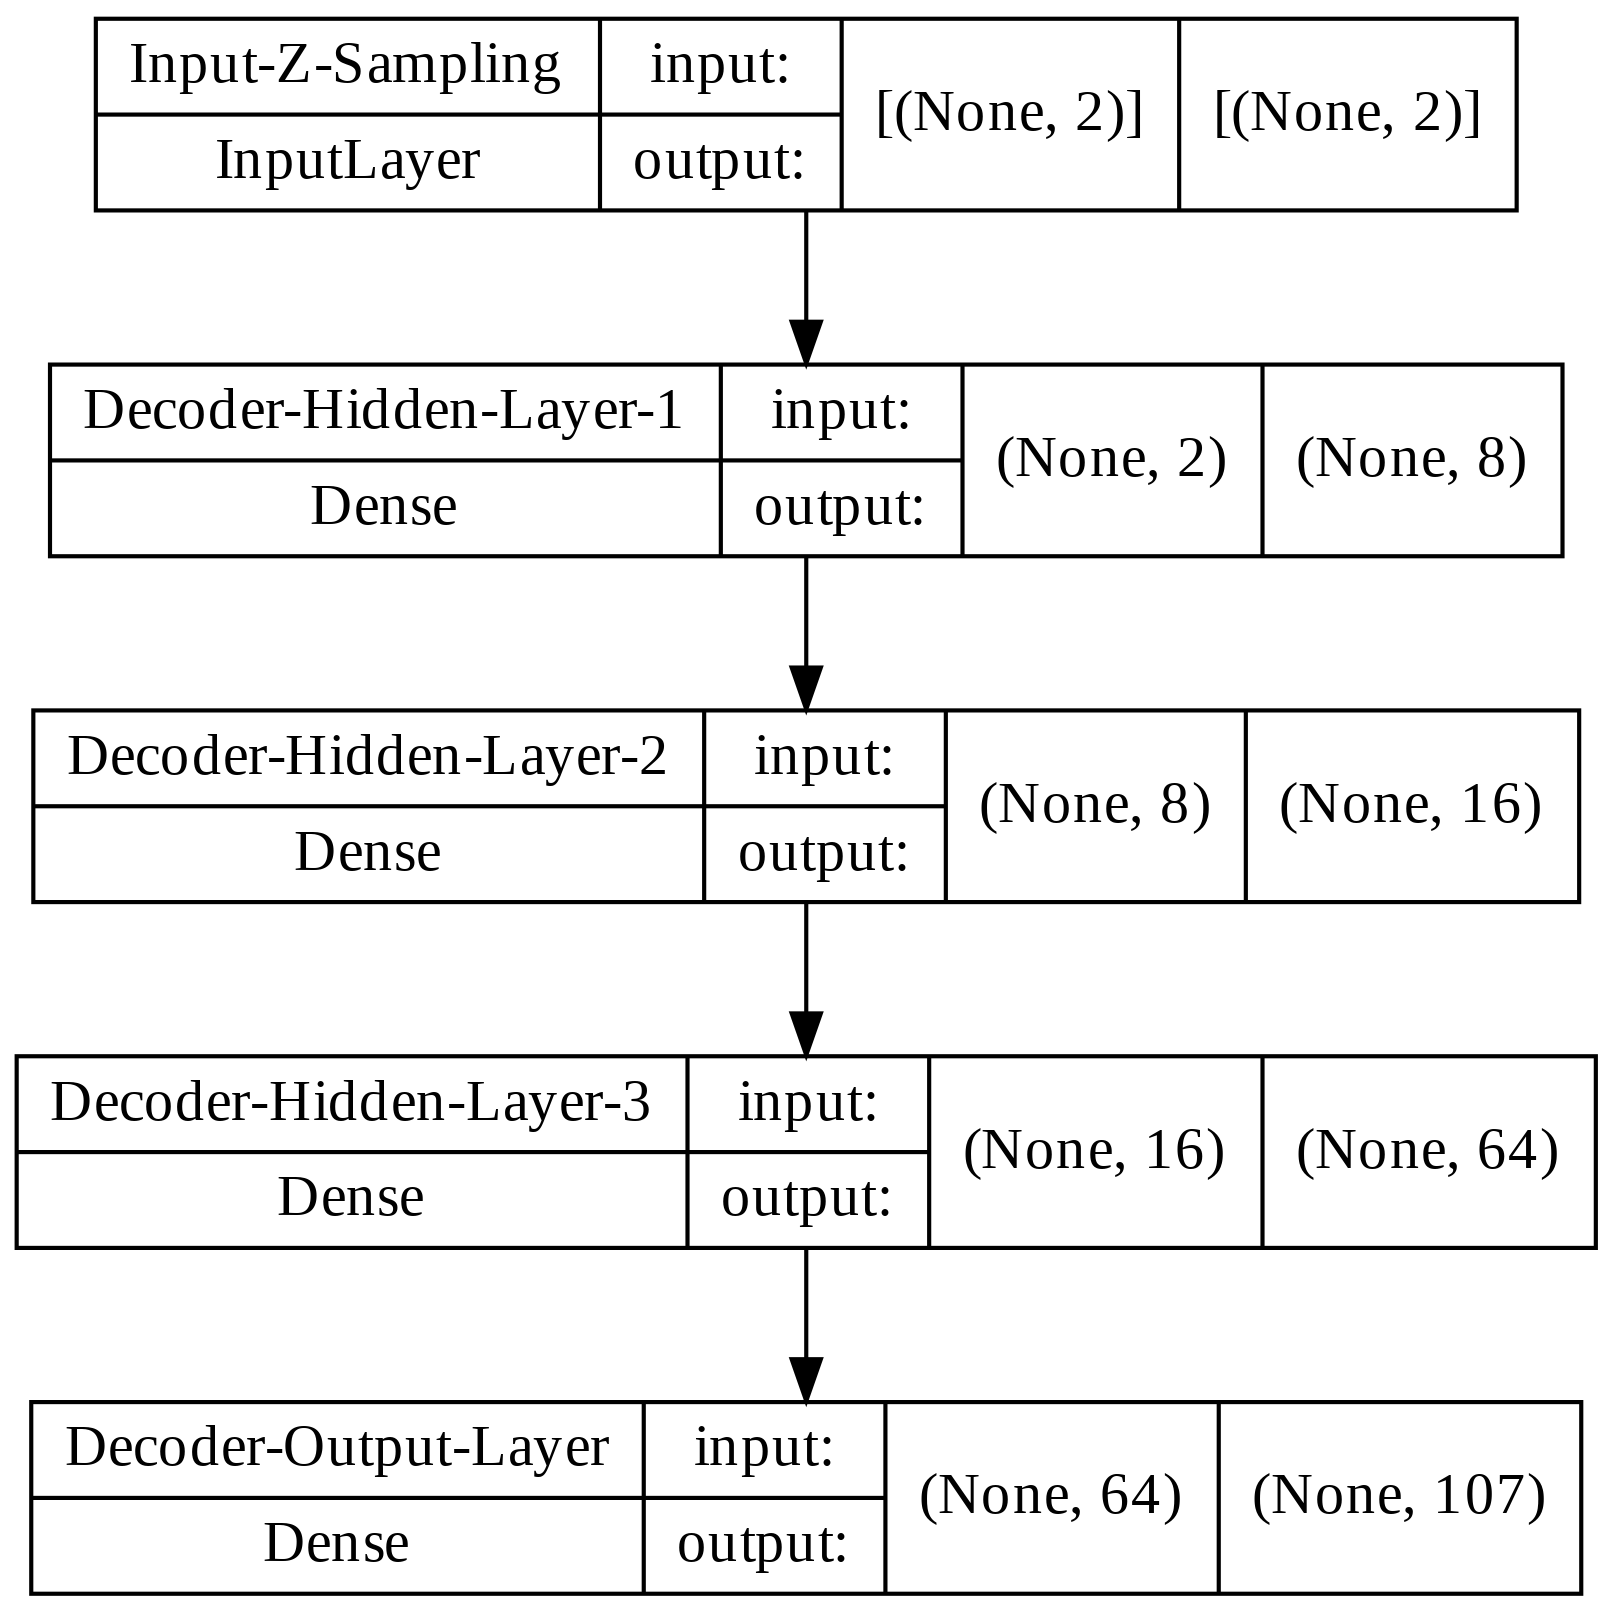

In [ ]:
## Decoder

latent_inputs = Input(shape=(latent_dim,), name='Input-Z-Sampling')

h_dec = Dense(units=8, activation='selu', name='Decoder-Hidden-Layer-1')(latent_inputs)
h_dec2 = Dense(units=16, activation='selu', name='Decoder-Hidden-Layer-2')(h_dec)
h_dec3 = Dense(units=64, activation='selu', name='Decoder-Hidden-Layer-3')(h_dec2)

outputs = Dense(original_dim, activation='sigmoid', name='Decoder-Output-Layer')(h_dec3)

decoder = Model(latent_inputs, outputs, name='Decoder-Model')

plot_model(decoder, show_shapes=True, dpi=300)

In [ ]:
## Autoencoder

outpt = decoder(encoder(visible)[2])
vae = Model(inputs=visible, outputs=outpt, name='VAE-Model')

In [ ]:
## Loss Function

r_loss = original_dim * keras.losses.mse(visible, outpt)
kl_loss = -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis = 1)
vae_loss = K.mean(r_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

Epoch 1/100
13/13 [==============================] - 1s 23ms/step - loss: 9.4087 - val_loss: 8.0018
Epoch 2/100
13/13 [==============================] - 0s 6ms/step - loss: 7.4463 - val_loss: 6.3888
Epoch 3/100
13/13 [==============================] - 0s 5ms/step - loss: 5.4164 - val_loss: 5.0646
Epoch 4/100
13/13 [==============================] - 0s 4ms/step - loss: 4.2758 - val_loss: 4.1465
Epoch 5/100
13/13 [==============================] - 0s 4ms/step - loss: 3.7231 - val_loss: 4.0487
Epoch 6/100
13/13 [==============================] - 0s 5ms/step - loss: 3.6487 - val_loss: 4.2003
Epoch 7/100
13/13 [==============================] - 0s 8ms/step - loss: 3.5977 - val_loss: 4.4501
Epoch 8/100
13/13 [==============================] - 0s 13ms/step - loss: 3.6026 - val_loss: 3.9017
Epoch 9/100
13/13 [==============================] - 0s 16ms/step - loss: 3.3774 - val_loss: 4.0920
Epoch 10/100
13/13 [==============================] - 0s 11ms/step - loss: 3.3279 - val_loss: 4.0341
Epoch

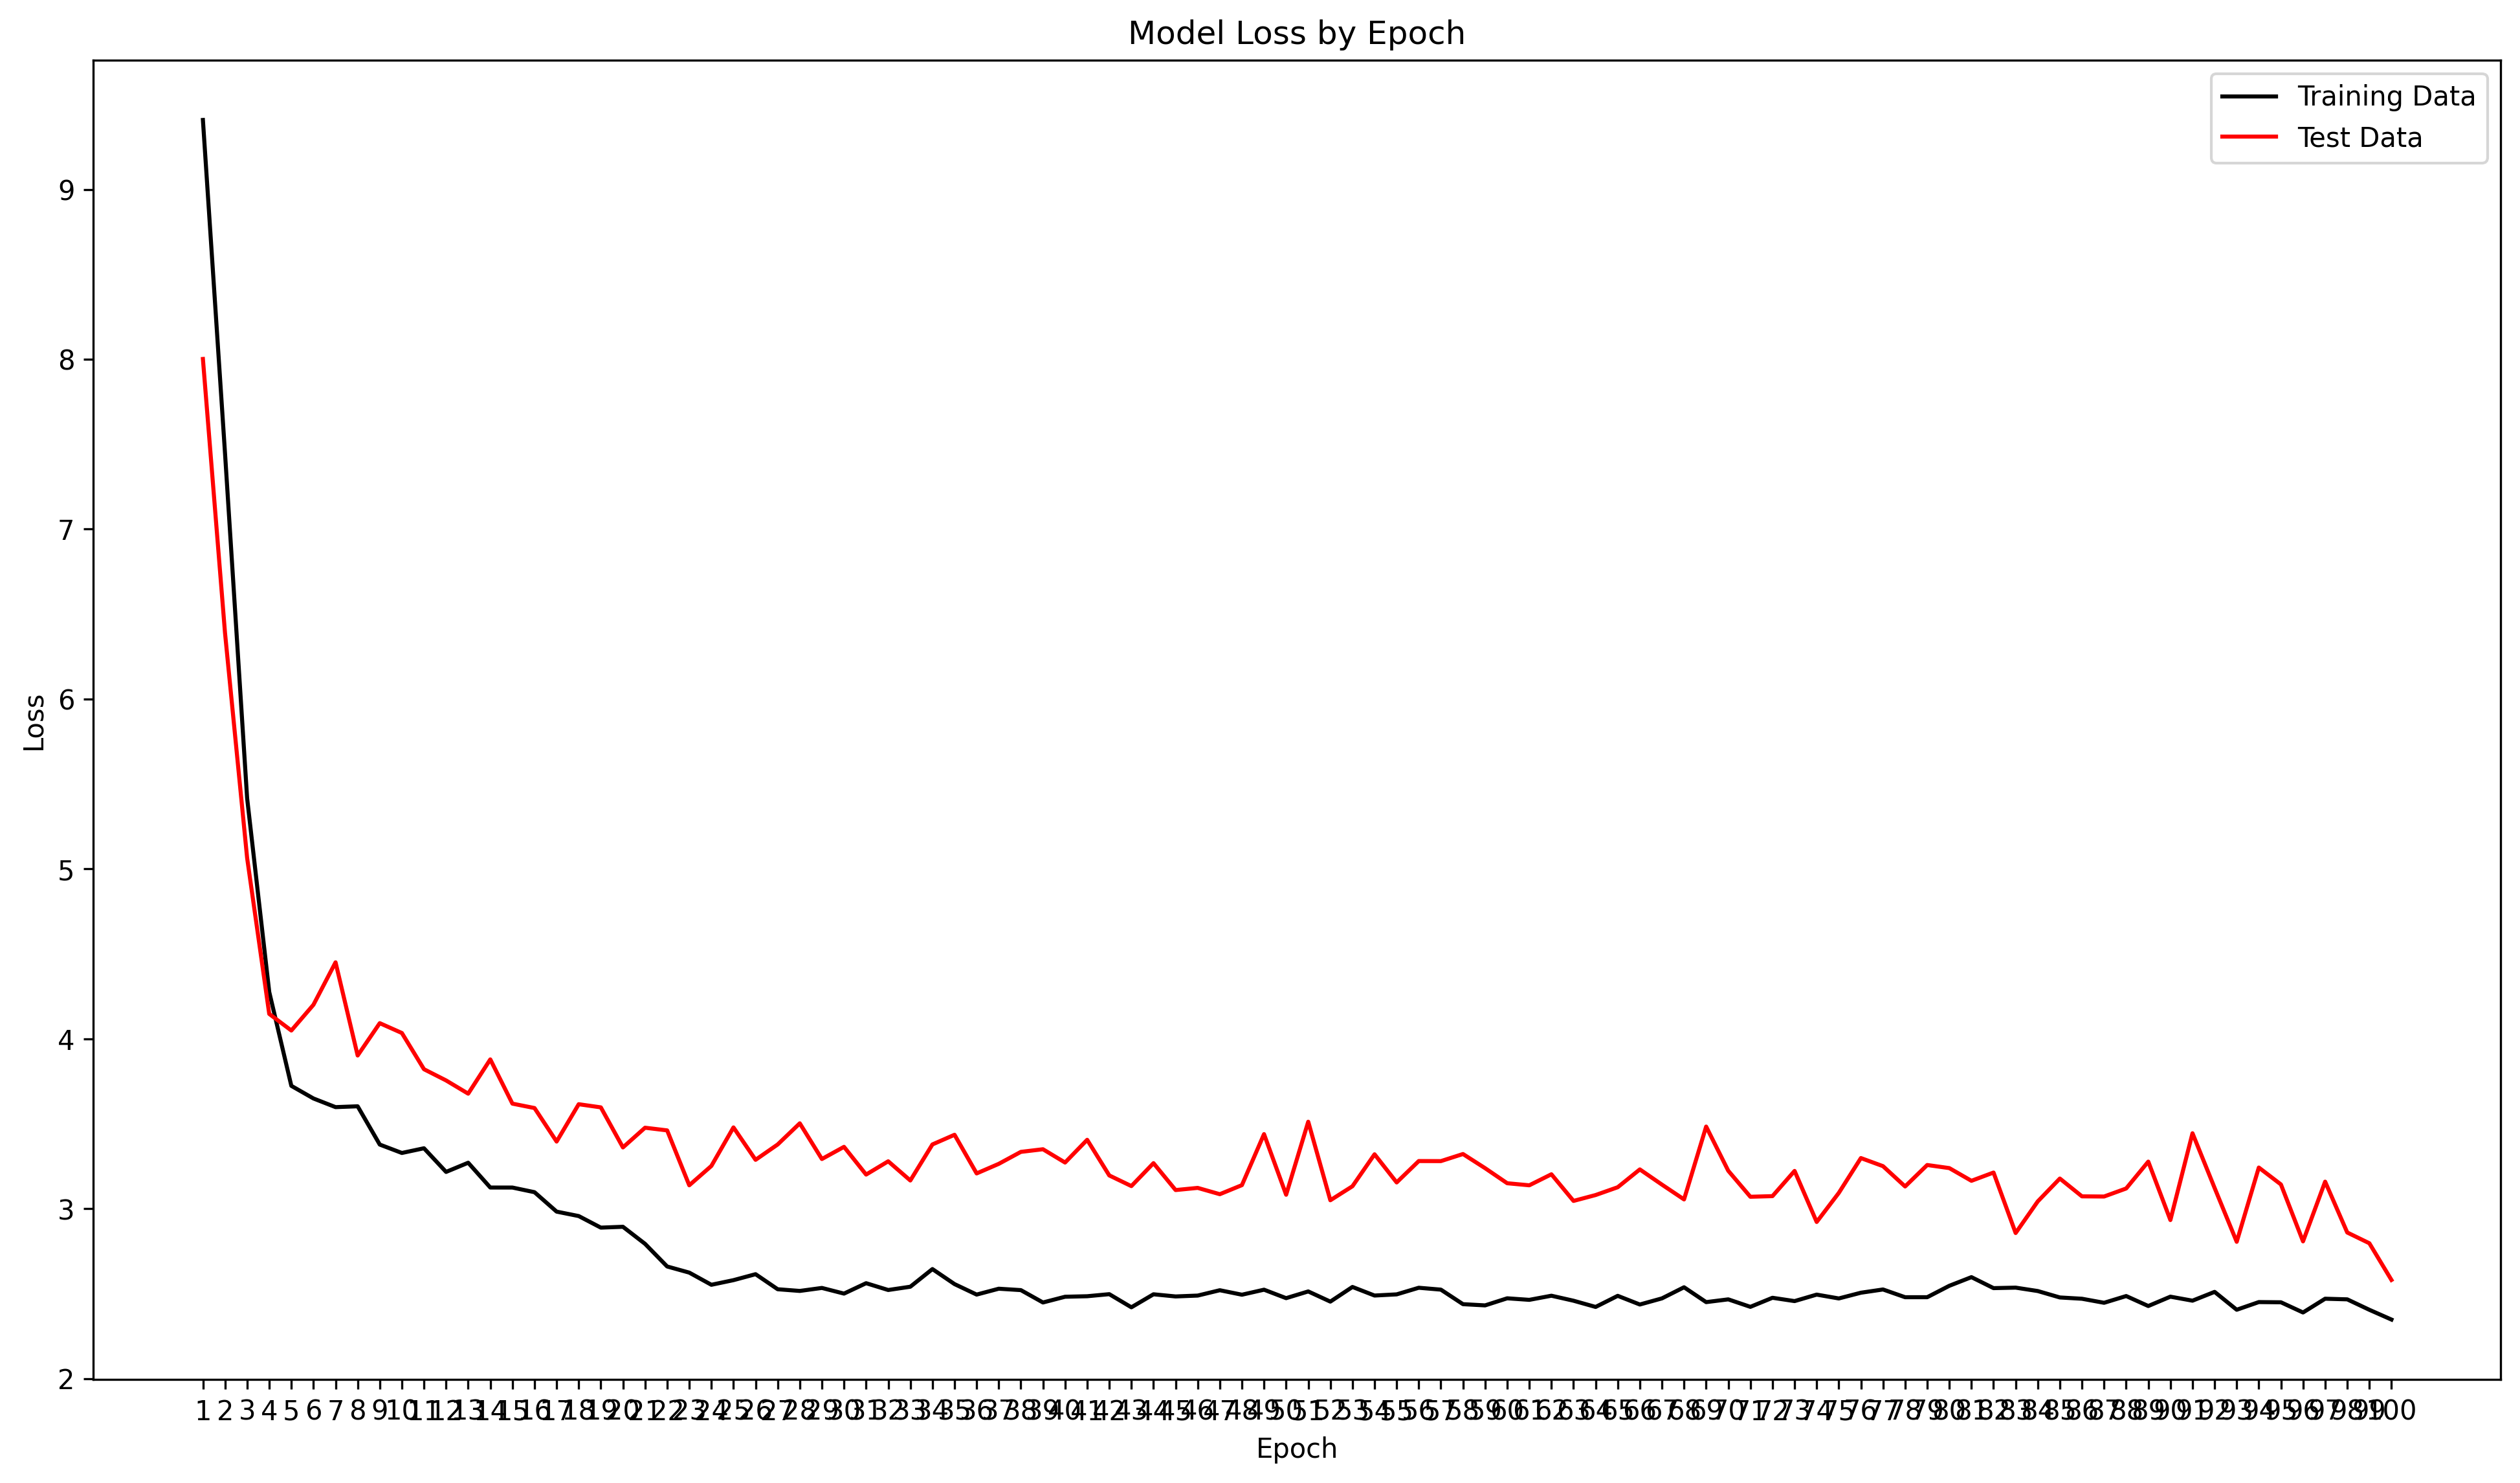

In [ ]:
## Training

history = vae.fit(X_train, X_train, epochs=100, batch_size=16, validation_data=(X_test, X_test))

fig, ax = plt.subplots(figsize=(16,9), dpi=300)
plt.title(label='Model Loss by Epoch', loc='center')

ax.plot(history.history['loss'], label='Training Data', color='black')
ax.plot(history.history['val_loss'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.xticks(ticks=np.arange(len(history.history['loss']), step=1), labels=np.arange(1, len(history.history['loss'])+1, step=1))
plt.legend()
plt.show()

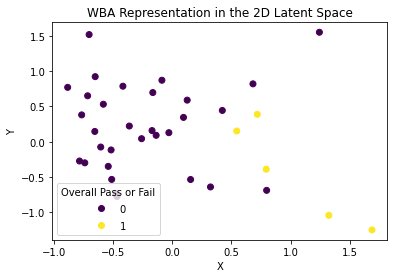

In [ ]:
## Visualise Latent Space

X_test_encoded = encoder.predict(X_test)

fig, ax = plt.subplots()
# encoder returns 3 arrays, z-mean, z-log-sigma, z
scatter = ax.scatter(X_test_encoded[2][:,0], X_test_encoded[2][:,1], c=y_test)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("WBA Representation in the 2D Latent Space")
ax.legend(*scatter.legend_elements(), loc="lower left", title="Overall Pass or Fail")
plt.show()

In [ ]:
## Generate from latent space

z_sample = [[-1.8,-0.3]]
wba_decoded = decoder.predict(z_sample)
wba_decoded[0]

array([0.08200064, 0.11684057, 0.12434828, 0.16026506, 0.18507159,
       0.18495396, 0.18884501, 0.19370246, 0.22047892, 0.19712558,
       0.23026267, 0.2505125 , 0.26717174, 0.3149074 , 0.36861733,
       0.40782544, 0.38620466, 0.4210968 , 0.41841835, 0.43831456,
       0.48907956, 0.49250478, 0.46468475, 0.5289872 , 0.53137046,
       0.5971906 , 0.59483325, 0.59861183, 0.5924121 , 0.6398034 ,
       0.67292905, 0.6730896 , 0.69294906, 0.7056078 , 0.73178077,
       0.73057336, 0.77957064, 0.7568048 , 0.77918255, 0.80431235,
       0.7535972 , 0.8003663 , 0.8082331 , 0.8213333 , 0.81923354,
       0.83466727, 0.83719796, 0.83902854, 0.8180877 , 0.8316026 ,
       0.8348641 , 0.82505095, 0.8193755 , 0.8059288 , 0.77833545,
       0.8242279 , 0.816195  , 0.81755424, 0.79742795, 0.80623853,
       0.80052274, 0.8302988 , 0.833814  , 0.84714997, 0.8501487 ,
       0.86231744, 0.8742565 , 0.8822555 , 0.8887154 , 0.903826  ,
       0.9010241 , 0.89947474, 0.90580356, 0.89109194, 0.92781

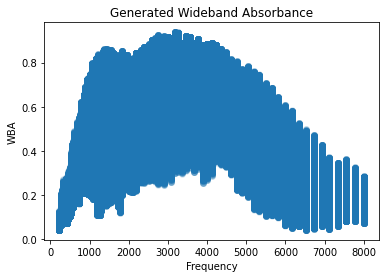

In [ ]:
# generate 10,000 samples

from random import seed
from random import random

seed(1)

n_samples = 10000
z_sample = []
x_range = 2
y_range = 2

for _ in range(n_samples):
  x_value = -x_range + (random() * (x_range*2))
  y_value = -y_range + (random() * (y_range*2))
  z_sample.append([x_value, y_value])

wba_decoded = decoder.predict(z_sample)
#unscaled = scaler.inverse_transform(wba_decoded)
#pd.DataFrame(unscaled).to_csv('sample.csv')
X_generated = pd.DataFrame(wba_decoded)
X_generated.columns = X_train.columns
X_generated['RowNum'] = np.arange(len(X_generated)) # use row number as identifier
frequencies = X_generated.iloc[:,:-1].columns

X_generated_long = pd.melt(X_generated, id_vars=['RowNum'], value_vars=frequencies, var_name='Frequency', value_name='WBA')
X_generated_long['Frequency'] = X_generated_long['Frequency'].str[2:-1].astype(float)

fig, ax = plt.subplots()
scatter = ax.scatter(X_generated_long["Frequency"], X_generated_long["WBA"], alpha=0.1)
ax.set_xlabel("Frequency")
ax.set_ylabel("WBA")
ax.set_title("Generated Wideband Absorbance")
plt.show()

In [ ]:
X_generated_long.to_csv('X_generated.csv')

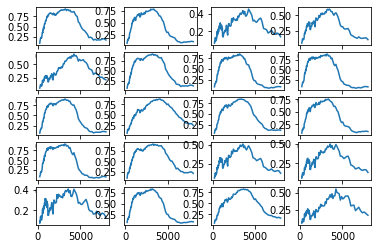

In [ ]:
from random import *

fig, ax = plt.subplots(5, 4)

for row in range(5):
  for col in range(4):
    sample = randint(1, 9999)
    data = X_generated_long[X_generated_long['RowNum'] == sample]
    ax[row, col].plot(data["Frequency"], data["WBA"])
plt.show()